In [1]:
import numpy as np
import torch

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# https://plotly.com/python/creating-and-updating-figures/
import plotly.graph_objects as go

In [3]:
import sys
sys.path.append('../') # now can access entire repository, (important when running locally)

from orbit_datasets import neworbits, versatileorbits, staticorbits

# Data Generation

In [4]:
orbits_dataset = neworbits.OrbitsDataset()
orbits_loader = torch.utils.data.DataLoader(
    dataset = orbits_dataset,
    shuffle = True,
    batch_size = 1,
)

Current dE:  [1.59872116e-14]
eccentricity:  [0.99214041]
Current dE:  [1.15463195e-14]
eccentricity:  [0.92853018]
It took 1.5895898342132568 time to finish the job.


In [5]:
ENCODER_PATH = "saved_models/orbits_mseNCE_encoder_model.pt"
branch_encoder = torch.load(ENCODER_PATH, map_location=torch.device('cpu'))
branch_encoder.eval()

branchEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=4, bias=True)
  )
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace

In [7]:
all_representations_neutral = []
target_values = []

for it, (input1, input2, y) in enumerate(orbits_loader):

    predicted_representation = branch_encoder(input1.float()).detach().numpy()[0]

    all_representations_neutral.append(np.array(predicted_representation))

    #append energies to the end of the representation for plotting

    #[phi0,energy,angular_momentum]
    target_values.append(np.array([y[0][2],y[0][3],y[0][4]]))

    """
    y target indices correspond to:

    0 = e = eccentricity
    1 = a = semimajor axis
    2 = phi0 = orientation of the orbit
    3 = H = energy
    4 = L = angular momentum
    """

all_representations = np.vstack(all_representations_neutral)
target_values = np.vstack(target_values)

In [8]:
num_shown = 6000

encoder_output_size = 3

"""
phi0 = 0
energy = 1
angular_momentum = 2
"""

dims = [all_representations[:num_shown,i] for i in range(encoder_output_size)]

phi0_c_values = target_values[:num_shown,0]
energy_c_values = target_values[:num_shown,1]
angular_momentum_c_values = target_values[:num_shown,2]

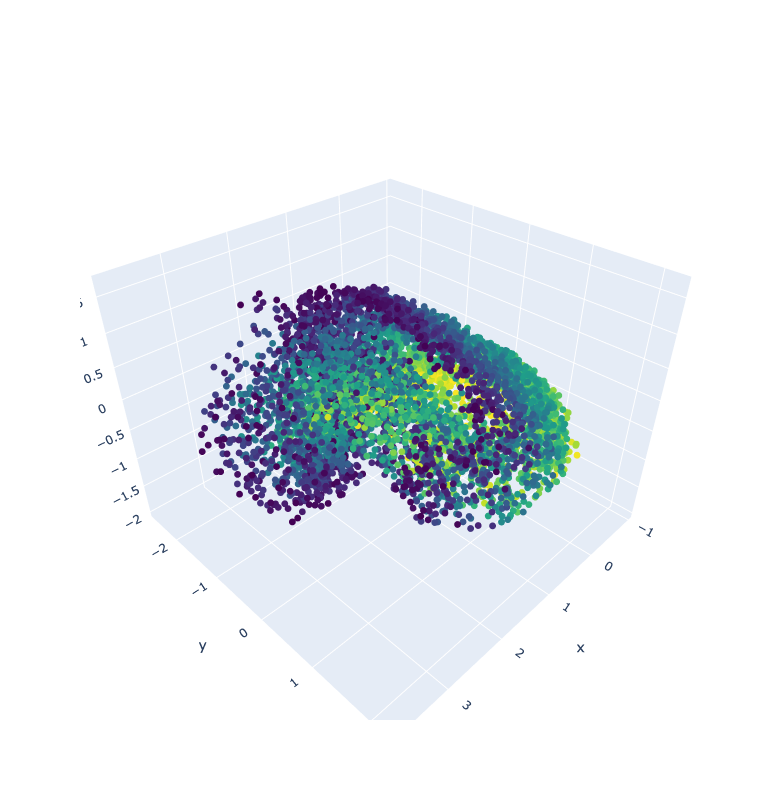

In [21]:
fig = go.Figure(
        data=[go.Scatter3d(
        x=dims[0],
        y=dims[1],
        z=dims[2],
        mode='markers',
        marker=dict(
            size=4,
            color=angular_momentum_c_values, # set color to an array/list of desired values
            colorscale='viridis',
            opacity=1
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()